## 01_IMPORTS

In [1]:
#General

import pandas as pd
import matplotlib.pyplot as plt


#Embeddings
import re
from nltk.corpus import stopwords
import keras
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Model
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gensim
#from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

#Recommender System mit SVD
from sklearn.decomposition import TruncatedSVD
import numpy as np
from scipy.sparse import csr_matrix
import implicit

# Images
from IPython.display import Image, display, HTML

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flaviopfister/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/flaviopfister/anaconda3/envs/rs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 02 LOAD DATA

In [2]:
rating_df = pd.read_csv('01_Data/books_rating.csv')
books_df = pd.read_csv('01_Data/books_data.csv')

In [27]:
rating_df.shape

(3000000, 10)

In [28]:
rating_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [29]:
#calculate how many users just gave one bad rating with 1 star
oneStar = rating_df[rating_df['review/score'] == 1].groupby('User_id').head(10)
print("Number of one star ratings: ", oneStar.shape[0])
print("Number of users with just one star rating: ", oneStar['User_id'].nunique())


Number of one star ratings:  146298
Number of users with just one star rating:  97503


In [30]:
# Fraction of NaN in Price
rating_df['Price'].isnull().sum()*100/len(rating_df)

83.96096666666666

## 03_DATA PREPROCESSING

In [31]:
# Drop Price Column
rating_df.drop('Price', axis=1, inplace=True)

In [32]:
# Drop review/helpfullnes column
rating_df.drop('review/helpfulness', axis=1, inplace=True)

In [33]:
# Drop review/summary column
rating_df.drop('review/summary', axis=1, inplace=True)

In [34]:
# Drop review/text column
rating_df.drop('review/text', axis=1, inplace=True)

In [35]:
# check amount off different Values in the Id Column
print("Number of unique Id: ", rating_df['Id'].nunique())
print("Number of unique Users: ", rating_df['User_id'].nunique())



Number of unique Id:  221998
Number of unique Users:  1008972


In [36]:
#Number of reviews per User
rating_df.groupby('profileName')['Id'].agg('count').sort_values(ascending=False).head(20)

profileName
Midwest Book Review                   5817
A Customer                            5016
Harriet Klausner                      3606
E. A Solinas "ea_solinas"             3146
Shalom Freedman "Shalom Freedman"     1995
Blue Tyson "- Research Finished"      1804
John                                  1699
Donald Mitchell "Jesus Loves You!"    1457
bernie "xyzzy"                        1387
Avid Reader                           1383
Charles Ashbacher                     1312
Chris                                 1129
Sarah                                 1044
Mike                                  1038
S. Schwartz "romonko"                 1031
Steven H. Propp                       1001
David                                  975
Lawyeraau                              961
Reader                                 959
Anonymous                              951
Name: Id, dtype: int64

In [37]:
# average number of reviews per user
rating_df.groupby('profileName')['Id'].agg('count').sort_values(ascending=False).mean()

2.8544275269421466

In [38]:
#reformat the review/time column to actual date
rating_df['review/time'] = pd.to_datetime(rating_df['review/time'], unit='s')

In [39]:
rating_df

,Id,Title,User_id,profileName,review/score,review/time
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,1999-10-23
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5.0,2004-09-21
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5.0,2004-03-09
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,2004-07-25
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,2005-02-10
...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,4.0,1999-09-18
2999996,B000NSLVCU,The Idea of History,A1SMUB9ASL5L9Y,jafrank,4.0,2012-03-14
2999997,B000NSLVCU,The Idea of History,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4.0,2007-05-27
2999998,B000NSLVCU,The Idea of History,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5.0,2006-11-09


array([[<Axes: title={'center': 'review/score'}>]], dtype=object)

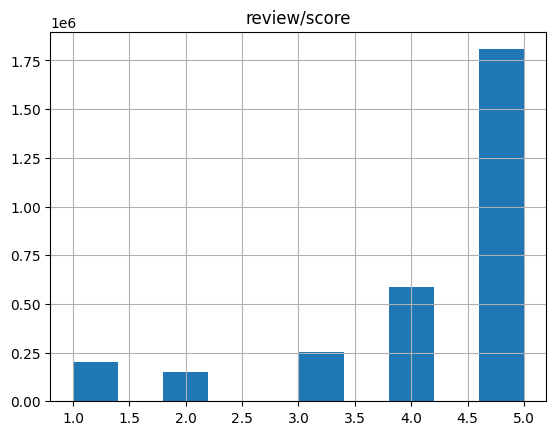

In [40]:
rating_df.hist('review/score')

## Books Dataset

In [3]:
books_df = pd.read_csv('01_Data/books_data.csv')
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [5]:
books_df.head(3)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN


In [6]:
# add the id from the rating_df to the books_df to get the book_id merging on the title
books_df = pd.merge(books_df, rating_df[['Id', 'Title']], on='Title', how='left')

In [10]:
# drop the duplicates
books_df.drop_duplicates(subset='Title', inplace=True)
# restet the index
books_df.reset_index(drop=True, inplace=True)


In [11]:
books_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN,1882931173
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,0829814000
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,0595344550
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN,0253338352
...,...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0,0590482467
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN,0570047870
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],NaN,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,NaN,B000OVF7JY
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0,1402508735


In [12]:
# Drop books with nan in image
# just for convenience with the show_image function later ;)

books_df.dropna(subset=['image'], inplace=True)
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160329 entries, 0 to 212403
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          160328 non-null  object 
 1   description    136957 non-null  object 
 2   authors        155027 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    160329 non-null  object 
 5   publisher      130183 non-null  object 
 6   publishedDate  159405 non-null  object 
 7   infoLink       160329 non-null  object 
 8   categories     151884 non-null  object 
 9   ratingsCount   47127 non-null   float64
 10  Id             160329 non-null  object 
dtypes: float64(1), object(10)
memory usage: 14.7+ MB


# Collabroative Filtering mit SVD

In [44]:
# Merge the two dataframes by Title
df = pd.merge(rating_df, books_df, on='Title')

# Drop the Id column
df.drop('ratingsCount', axis=1, inplace=True) # seems to be wrong data

# Count numbers of reviews per book and add it to the dataframe
df['number_of_reviews'] = df.groupby('Title')['Title'].transform('count')

len(df)

2459694

In [45]:
# drop all books with less than 50 reviews

df = df[df['number_of_reviews'] >= 50]
len(df)

1509689

In [46]:
# drop unnecessary columns
df.drop('profileName', axis=1, inplace=True)
df.drop('review/time', axis=1, inplace=True)
df.drop('description', axis=1, inplace=True)
df.drop('authors', axis=1, inplace=True)
df.drop('previewLink', axis=1, inplace=True)
df.drop('publisher', axis=1, inplace=True)
df.drop('image', axis=1, inplace=True)
df.drop('publishedDate', axis=1, inplace=True)
df.drop('infoLink', axis=1, inplace=True)
df.drop('categories', axis=1, inplace=True)
#df.drop('ratingsCount', axis=1, inplace=True)

# rename the column
df.rename(columns={'review/score': 'rating'}, inplace=True)
df.rename(columns={'Id': 'book_id'}, inplace=True)
df.rename(columns={'Title': 'title'}, inplace=True)
df.rename(columns={'User_id': 'user_id'}, inplace=True)

df

,book_id,title,user_id,rating,number_of_reviews
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0
361,0671551345,Night World: Daughters Of Darkness,NaN,5.0,134.0
362,0671551345,Night World: Daughters Of Darkness,NaN,3.0,134.0
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0
364,0671551345,Night World: Daughters Of Darkness,NaN,5.0,134.0
...,...,...,...,...,...
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0
2459397,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,NaN,1.0,96.0
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0


In [47]:
# show all ratings from User AZZQLMNX239VT
df[df['user_id'] == 'AZZQLMNX239VT']

,book_id,title,user_id,rating,number_of_reviews
913204,B000P5ISWW,The Brothers Karamazov: A Modern Library Book ...,AZZQLMNX239VT,4.0,119.0
1103862,B000I364KE,Anna Karenina - translated from the Russian by...,AZZQLMNX239VT,5.0,505.0
1222166,B000MCJWZ0,Anna Karenina,AZZQLMNX239VT,5.0,850.0
2317819,B000GR6DWQ,The Brothers Karamazov (A Signet Classic CT33),AZZQLMNX239VT,4.0,120.0


In [48]:
# drop all reviews with NaN user_id just for convenience at the moment
df = df.dropna(subset=['user_id'])
df

,book_id,title,user_id,rating,number_of_reviews
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0
366,0671551345,Night World: Daughters Of Darkness,AODBNCTX9L1L5,5.0,134.0
378,0671551345,Night World: Daughters Of Darkness,A107F528SN3XJU,5.0,134.0
380,0671551345,Night World: Daughters Of Darkness,AXYESYR1GNGM0,5.0,134.0
...,...,...,...,...,...
2459394,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2NNMPFZWPMT1L,5.0,96.0
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0


In [49]:
# Count numbers of reviews per user and add it to the dataframe
df['number_of_reviews_user'] = df.groupby('user_id')['user_id'].transform('count')
df

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_33211/3449723507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_reviews_user'] = df.groupby('user_id')['user_id'].transform('count')


,book_id,title,user_id,rating,number_of_reviews,number_of_reviews_user
360,0671551345,Night World: Daughters Of Darkness,ADB0JID2XRFYR,5.0,134.0,1
363,0671551345,Night World: Daughters Of Darkness,A1V0SFB3AXM8JK,1.0,134.0,2
366,0671551345,Night World: Daughters Of Darkness,AODBNCTX9L1L5,5.0,134.0,1
378,0671551345,Night World: Daughters Of Darkness,A107F528SN3XJU,5.0,134.0,3
380,0671551345,Night World: Daughters Of Darkness,AXYESYR1GNGM0,5.0,134.0,2
...,...,...,...,...,...,...
2459394,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2NNMPFZWPMT1L,5.0,96.0,2
2459395,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,A2E55F0514C3UG,1.0,96.0,1
2459396,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AUEN15WF0UAMJ,1.0,96.0,1
2459398,B000HOMU48,Cracking Da Vinci's Code: You've Read the Fict...,AWF6YB8EKN2C6,2.0,96.0,1


In [50]:
# Only use users with more than 5 reviews
df = df[df['number_of_reviews_user'] >= 5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599131 entries, 382 to 2459399
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   book_id                 599131 non-null  object 
 1   title                   599131 non-null  object 
 2   user_id                 599131 non-null  object 
 3   rating                  599131 non-null  float64
 4   number_of_reviews       599131 non-null  float64
 5   number_of_reviews_user  599131 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 32.0+ MB


## Collaborative with Surprise Package

In [51]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from surprise import accuracy

In [52]:
# only use the columns book_id, user_id and rating
df_surprise = df[['book_id', 'user_id', 'rating']]
df_surprise

,book_id,user_id,rating
382,0671551345,A2KBHSK5BS35BH,1.0
383,0671551345,AAGXEK8SQP7FB,5.0
414,0671551345,AZRCQEVXXL78E,4.0
415,0671551345,A31HGIGKNKCC2C,4.0
419,0671551345,A2WZON0QPX7C9X,5.0
...,...,...,...
2459374,B000HOMU48,A3P61OHXDKDQ7W,1.0
2459377,B000HOMU48,A2FOT0QE23VN6J,1.0
2459381,B000HOMU48,A3PSGJREO570YX,1.0
2459387,B000HOMU48,A3FCJWWZHV2FJH,1.0


### mit SVD

In [53]:
reader = Reader(rating_scale=(1, 5))

# Laden der Daten in ein Surprise-Dataset
data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)

# Initialisierung des SVD-Modells
algo = SVD()

# Führen einer 5-fachen Kreuzvalidierung durch
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Trainieren des Modells mit dem gesamten Datensatz
trainset = data.build_full_trainset()
algo.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6654  0.6627  0.6600  0.6638  0.6591  0.6622  0.0024  
MAE (testset)     0.4221  0.4202  0.4195  0.4216  0.4186  0.4204  0.0013  
Fit time          3.73    3.67    3.69    3.64    3.67    3.68    0.03    
Test time         0.58    0.51    0.52    0.52    0.32    0.49    0.09    


In [54]:
# Source: https://github.com/leammurphy/books-rs/blob/main/book_RS.ipynb

from surprise.model_selection import train_test_split 

# Take a subset of the df so it runs faster, you might have to take an even smaller subset
subset = df_surprise.sample(n=20000, random_state=187)

# Define the reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into Surprise's Dataset object
data = Dataset.load_from_df(subset[['user_id', 'book_id', 'rating']], reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.2)

# Instantiate the algorithm
algo = SVD()

# Train the model
algo.fit(trainset)

In [55]:
# unique users in testset to list
# just for random predictions later
unique_users_test = subset.user_id.unique().tolist()

In [56]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [57]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [58]:
rmse = accuracy.rmse(predictions)

RMSE: 0.2106


In [59]:
# Map book_id to book title
id_to_title = dict(zip(df['book_id'], df['title']))

### Predictions for a single user - Productiv

In [60]:
# function to get a random user_id from the testset
import random

def get_random_user():
    return random.choice(unique_users_test)

In [61]:
# funktion die die Top N Empfehlungen für einen spezifischen User ausgibt

def get_top_n_for_user(predictions, user_id, n):
    """Return the top-N recommendation for a specific user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        user_id(str): The user id for which to return the top-N recommendation.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A list of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = []
    for uid, iid, true_r, est, _ in predictions:
        if uid == user_id:
            top_n.append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    top_n.sort(key=lambda x: x[1], reverse=True)
    top_n = top_n[:n]

    # Map book_id to book title
    top_n = [(id_to_title[iid], est) for (iid, est) in top_n]

    # a list with only the book titles
    book_titles = [iid for (iid, est) in top_n]

    return book_titles, top_n

In [62]:
# Function to display the images of the books 

# may need to be reworked!!

def display_books_in_row(titles, urls):
    images = [Image(url=url, width=150, height=190) for url in urls]
    display(HTML("<div>" + "".join([f"<div style='display:inline-block; padding:10px; text-align:center;'>{image._repr_html_()}<br>{title}</div>" for image, title in zip(images, titles)]) + "</div>"))    


In [63]:
# Function to get the links to the books given as parameter

def get_book_links(book_ids):
    """
    Diese Funktion gibt die Links zu den Büchern zurück.
    
    :param book_ids: Die Buch-IDs für die Links zurückgegeben werden sollen.
    :return: Eine Liste der Links zu den Büchern.
    """
    links = []
    for book_id in book_ids:
        links.append(books_df[books_df['Title'] == book_id]['image'].values[0])
    return links

In [64]:
# Recommendation Function

def get_recommendation(user_id, n):
    # top_n beinhaltet auch die predicteten Ratings falls später gebraucht
    books , top_n = get_top_n_for_user(predictions, user_id, n)
    urls = get_book_links(books)
    print(f"Vorschläge für User ID: {user_id}")
    display_books_in_row(books, urls)
    return top_n

In [65]:
user_id = get_random_user()

In [66]:
collaborativ_recs = get_recommendation(get_random_user(), 6)

Vorschläge für User ID: A071300825Y5MYNM1L3LX


In [67]:
# For later Mix with Content Based

collaborativ_recs

[('George Orwell 1984', 4.75697604059749),
 ('God Calling', 4.756644442698701),
 ('The Hobbit', 4.753552962230093),
 ('Mere Christianity', 4.719916463655808),
 ('The Killer Angels (Turtleback School & Library Binding Edition)',
  4.709986132905388),
 ('Little Women: or Meg, Jo, Beth, and Amy', 4.692779218855125)]

# Content Based Filtering

> Vectorize descripton of the books and use it for calculating the similarity between the books

In [14]:
books_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN,1882931173
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,0829814000
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,0595344550


In [174]:
# get description of the book with index 1
books_df.loc[3, 'description']

'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance an

In [15]:
# Drop all rows with NaN values in the description column
# Word2Vec Tokenizer hat Probleme mit NaN Values

books_df = books_df.dropna(subset=['description'])
books_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,0829814000
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,0595344550
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,0802841899
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],http://books.google.com/books/content?id=lmLqA...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,Tan Books & Pub,2009-01-01,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,['Biography & Autobiography'],NaN,0895554224


In [16]:
# check how many Nan values in the description column
books_df.description.isna().sum()

0

In [17]:
# fraction of Nan values in the description column
books_df.description.isna().sum() / len(books_df)

0.0

# Embedding mit Roberta

In [18]:
import torch
from transformers import RobertaModel, RobertaTokenizer
 
def get_roberta_embedding(text, model, tokenizer):
    """
    Get the embedding for a given text using RoBERTa.
   
    Args:
    - text (str): The input text for which to get the embedding.
    - model (RobertaModel): The RoBERTa model.
    - tokenizer (RobertaTokenizer): The tokenizer corresponding to the model.
   
    Returns:
    - torch.Tensor: The embedding of the input text.
    """
    # Tokenize the input text
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=512)['input_ids']
   
    # Get model outputs. The output for RoBERTa is a tuple where the first item is the sequence of hidden-states.
    with torch.no_grad():
        output = model(input_ids)
   
    # Use the hidden state of the first token ([CLS] in BERT's case, <s> in RoBERTa's case) as the embedding
    return output[0][:,0,:]

In [19]:
# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 # Example usage VON GARVIN!!!!!
book_summaries = descriptions_sub
embeddings = [get_roberta_embedding(summary, model, tokenizer) for summary in book_summaries]
 
# Convert to numpy if needed
embeddings_np = [e.numpy() for e in embeddings]

In [20]:
# make a dictionary with all the descriptions and the index as key
description_dict = dict(zip(books_df['Id'], books_df['description']))
description_dict

{'0826414346': 'Philip Nel takes a fascinating look into the key aspects of Seuss\'s career - his poetry, politics, art, marketing, and place in the popular imagination." "Nel argues convincingly that Dr. Seuss is one of the most influential poets in America. His nonsense verse, like that of Lewis Carroll and Edward Lear, has changed language itself, giving us new words like "nerd." And Seuss\'s famously loopy artistic style - what Nel terms an "energetic cartoon surrealism" - has been equally important, inspiring artists like filmmaker Tim Burton and illustrator Lane Smith. --from back cover',
 '0829814000': 'This resource includes twelve principles in understanding small church worship, fifteen practices for planning worship with fewer than 100 people, and suggestions for congregational study.',
 '0595344550': 'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him wit

In [ ]:
# von hier müssen wir 1000 zufällig nehmen und dann die embeddings berechnen
# die ID muss erhalten bleiben!!!


In [89]:
descriptions = books_df['description'].tolist()

In [153]:
# Zufällige Auswahl von 1000 Schlüssel-Wert-Paaren aus dem Dictionary
random_entries = random.sample(description_dict.items(), k=1000)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [92]:
 # Example usage
book_summaries = descriptions_sub
embeddings = [get_roberta_embedding(summary, model, tokenizer) for summary in book_summaries]
 
# Convert to numpy if needed
embeddings_np = [e.numpy() for e in embeddings]

In [93]:
# a user_id from the testset
user_id = get_random_user()

In [94]:
# Function to get the book_id of a users best rated book

def get_best_rated_book(user_id):
    """
    Diese Funktion gibt das Buch mit der besten Bewertung für einen User zurück.
    
    :param user_id: Die ID des Users für den das Buch mit der besten Bewertung zurückgegeben werden soll.
    :return: Das Buch mit der besten Bewertung für den User.
    """
    return df[df['user_id'] == user_id].sort_values('rating', ascending=False).iloc[0]['book_id']


In [95]:
get_best_rated_book(user_id)   

'B000868KD0'

In [122]:
# convert the book_id to the title
best_book_desc = id_to_title[get_best_rated_book(user_id)]

In [123]:
best_book_emb = get_roberta_embedding(best_book_desc,model, tokenizer)[0].numpy()

In [130]:
best_book_emb

array([-1.09358519e-01,  5.06306812e-02, -1.02357134e-01, -9.25682019e-03,
        1.43053085e-01, -1.80328056e-01, -7.68418610e-02, -6.98415861e-02,
        1.66481704e-01, -1.95803434e-01,  6.51368350e-02,  5.09236827e-02,
        5.04538752e-02, -1.65191367e-01, -1.82441026e-02,  1.13261081e-02,
       -7.88740516e-02,  1.46069005e-02,  5.07321209e-04, -1.00008294e-01,
       -2.07992867e-02,  8.51242840e-02,  3.27938080e-01,  1.77542776e-01,
        8.90320390e-02,  1.26763552e-01,  1.06396608e-01,  5.99646270e-02,
       -4.95755896e-02, -4.20863405e-02,  1.21853337e-01,  3.07797790e-02,
        1.82626829e-01, -1.33358359e-01,  1.30404025e-01,  1.45481542e-01,
        8.88834223e-02, -1.29811928e-01,  5.19274101e-02,  5.26738763e-02,
       -1.19362280e-01,  8.76966417e-02,  1.30828425e-01,  5.93780279e-02,
        6.19815663e-02,  9.85497236e-03,  1.33831248e-01,  1.12463929e-01,
        8.08754563e-02,  9.87951756e-02,  2.78322529e-02, -1.97962403e-01,
       -2.90012248e-02, -

In [133]:
embeddings_np

[array([[-6.23436570e-02,  5.73531240e-02,  2.27275006e-02,
         -2.72517148e-02,  1.29203483e-01, -1.49252027e-01,
         -4.10371050e-02,  4.58931923e-02,  8.31424892e-02,
          6.16099685e-04, -1.71408132e-02,  3.99833880e-02,
          9.94300246e-02,  4.09703329e-03,  8.32878575e-02,
         -6.91211373e-02, -5.30154966e-02,  6.41307086e-02,
         -4.32904810e-04, -1.29243478e-01, -5.45200482e-02,
          3.79706547e-03,  6.31153882e-02,  6.47272542e-02,
         -1.67126730e-02,  7.64513612e-02,  1.65508032e-01,
          8.42558444e-02, -1.11501500e-01,  1.09761097e-01,
         -3.42112333e-02,  3.24910022e-02,  1.20250359e-01,
          1.81641877e-02, -8.64777416e-02,  1.00556955e-01,
         -6.57812506e-03, -1.66413784e-02, -5.43272980e-02,
          7.27090091e-02, -3.19126584e-02,  1.28451198e-01,
         -1.68259516e-02,  2.14139353e-02,  7.99694210e-02,
          9.97221842e-03,  3.03732362e-02,  9.18360800e-03,
          4.47670110e-02,  4.61640954e-0

In [134]:
from sklearn.metrics.pairwise import cosine_similarity

# Berechnen Sie die Kosinus-Ähnlichkeit zwischen best_book_emb und allen Embeddings in embeddings_np
similarities = cosine_similarity(best_book_emb.reshape(1, -1), embeddings_np)

# Finden Sie die Indizes der ähnlichsten Embeddings
top_indices = similarities[0].argsort()[-5:][::-1]

# Drucken Sie die ähnlichsten Embeddings
for index in top_indices:
    print(embeddings_np[index])


ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.

In [135]:
# Angenommen, die Form von embeddings_np ist (a, b, c)
# Sie können es in die Form (a, b*c) umformen
embeddings_np = embeddings_np.reshape(embeddings_np.shape[0], -1)

# Ähnlich, wenn best_book_emb die Form (a, b, c) hat
# Sie können es in die Form (1, b*c) umformen
best_book_emb = best_book_emb.reshape(1, -1)

# Dann können Sie die Kosinus-Ähnlichkeit berechnen
similarities = cosine_similarity(best_book_emb, embeddings_np)

AttributeError: 'list' object has no attribute 'reshape'

In [141]:
import numpy as np

# Konvertieren Sie die Listen in NumPy-Arrays
embeddings_np = np.array(embeddings_np)
best_book_emb = np.array(best_book_emb)

# Jetzt können Sie reshape aufrufen
embeddings_np = embeddings_np.reshape(embeddings_np.shape[0], -1)
best_book_emb = best_book_emb.reshape(1, -1)

# Dann können Sie die Kosinus-Ähnlichkeit berechnen
similarities = cosine_similarity(best_book_emb, embeddings_np)

# Finden Sie die Indizes der ähnlichsten Embeddings
top_indices = similarities[0].argsort()[-5:][::-1]
top_indices

# get description of the books from the descriptions_sub list
books = [descriptions_sub[index] for index in top_indices]
books

# get book titles from the books list


['An unabridged republication of the 1921 classic in which Lightfoot encounters animal friends Peter Rabbit, Sammy Jay, Paddy the Beaver and others.',
 'In this thoroughly revised and expanded edition of a milestone study, a careful explanation of four essential cultural themes offers readers a window into how early Christians sustained commitment to distinctly Christian identity and practice, and with it, a new appreciation of the New Testament, the gospel, and Christian discipleship.',
 'A study guide covering the elective MCSE Exam series prepares the professional for exams on TCP/IP on NT 4, Internet Information Server 4, Internet Explorer administration, SQL Server 7, and Exchange Server 5.5',
 'Midlife is more than a crisis. It is a summons to grow and a challenge to change. Midlife beckons one inward. It is a move to interiority, a passage to the deeper places where we discover our authenticity, where we realize both our limitations and our grandeur.',
 'Designed as a quick and 

In [ ]:
books_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],http://books.google.com/books/content?id=lmLqA...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,Tan Books & Pub,2009-01-01,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,['Biography & Autobiography'],NaN
...,...,...,...,...,...,...,...,...,...,...
212398,Autodesk Inventor 10 Essentials Plus,Autodesk Inventor 2017 Essentials Plus provide...,"['Daniel Banach', 'Travis Jones']",http://books.google.com/books/content?id=zxHRC...,http://books.google.com/books?id=zxHRCwAAQBAJ&...,SDC Publications,2016-03,https://play.google.com/store/books/details?id...,['Computers'],NaN
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0


# Embedding mit Doc2Vec

In [23]:
books_df.head(4)

NameError: name 'books_df' is not defined

In [24]:
# Prepare Data for Word2Vec

tagged_data = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) for i, text in enumerate(books_df['description'])]

NameError: name 'books_df' is not defined

In [69]:
# Train the Word2Vec Model

model = Doc2Vec(vector_size=250, window=5, min_count=1, epochs=10)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [70]:
# just for testing purposes

text_to_embed = 'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance and bending the laws of love.'
embeddings = model.infer_vector(word_tokenize(text_to_embed.lower()))

In [71]:
# Shape of the Embeddings

embeddings.shape

(250,)

In [72]:
# Calculate the similarity between the embeddings and the documents in the model
# uses Test-Embedding from manual input

similar_documents = model.docvecs.most_similar(positive=[embeddings])

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_92616/1438082980.py:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_documents = model.docvecs.most_similar(positive=[embeddings])


In [73]:
# Check results

similar_documents

[('2', 0.8339560627937317),
 ('10197', 0.5663159489631653),
 ('105902', 0.5215837359428406),
 ('97203', 0.5134956240653992),
 ('69482', 0.5117202997207642),
 ('81420', 0.5093767046928406),
 ('48985', 0.5089392066001892),
 ('23586', 0.5079100131988525),
 ('48505', 0.5071102976799011),
 ('37169', 0.5042781233787537)]

In [75]:
# berechne Embeddings für alle Bücher und speichere sie als Liste in der Spalte 'embeddings'
books_df['embeddings'] = books_df['description'].apply(lambda x: model.infer_vector(word_tokenize(x.lower())))
books_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,embeddings
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,"[-0.17830664, -0.06724536, -0.033768427, 0.024..."
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,"[-0.07342331, -0.03741641, -0.17169109, -0.042..."
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,"[-0.41574353, -0.041447777, -0.29338163, 0.292..."
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,"[0.13385248, 0.13886231, 0.10494283, -0.128222..."


In [21]:
# save the dataframe as csv
books_df.to_csv('01_Data/books_data_embeddings.csv', index=False)


In [22]:
# load the dataframe
new_df = pd.read_csv('01_Data/books_data_embeddings.csv')
new_df.head(4)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,embeddings
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,[-0.07961161 0.03540632 0.02624479 -0.144790...
1,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,[-0.02649175 -0.09063662 0.07062624 0.024100...
2,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,[ 0.1185066 0.32673895 0.31888542 0.437906...
3,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,[ 0.05028091 0.2058532 0.04828251 0.116049...


In [74]:
# Needs to be changed!
# Problem with saving a coma separeted python list as a csv ;)


In [7]:
import torch
from transformers import RobertaModel, RobertaTokenizer
 
def get_roberta_embedding(text, model, tokenizer):
    """
    Get the embedding for a given text using RoBERTa.
   
    Args:
    - text (str): The input text for which to get the embedding.
    - model (RobertaModel): The RoBERTa model.
    - tokenizer (RobertaTokenizer): The tokenizer corresponding to the model.
   
    Returns:
    - torch.Tensor: The embedding of the input text.
    """
    # Tokenize the input text
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=512)['input_ids']
   
    # Get model outputs. The output for RoBERTa is a tuple where the first item is the sequence of hidden-states.
    with torch.no_grad():
        output = model(input_ids)
   
    # Use the hidden state of the first token ([CLS] in BERT's case, <s> in RoBERTa's case) as the embedding
    return output[0][:,0,:]
 
# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
 
# Example usage
book_summaries = ["Summary 1"]
embeddings = [get_roberta_embedding(summary, model, tokenizer) for summary in book_summaries]
 
# Convert to numpy if needed
embeddings_np = [e.numpy() for e in embeddings]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
embeddings_np[0][0].shape

(768,)

tensor([-6.1926e-02,  1.3198e-01, -3.7135e-02, -1.4797e-01,  1.1341e-01,
        -2.1557e-01, -1.1228e-01,  4.2656e-02,  2.2612e-01, -3.6016e-02,
        -1.0729e-02, -9.8409e-02,  9.2553e-02,  3.6186e-02,  1.1914e-01,
         5.2184e-02, -2.2350e-01,  5.9040e-02,  2.6274e-02, -1.1107e-01,
        -6.1501e-02,  7.2497e-02,  1.2448e-02,  9.5678e-02,  3.3215e-02,
         1.1327e-01,  1.3120e-03,  1.8500e-01,  4.0468e-02,  4.5874e-03,
         4.2868e-02, -6.9487e-02,  6.1722e-02,  4.0175e-02,  7.2184e-02,
         1.3951e-01,  8.6913e-02, -6.9557e-02, -5.8732e-02, -1.1999e-02,
         5.8908e-02,  1.0276e-01,  6.5910e-02,  5.5217e-02, -6.8911e-03,
         1.2585e-02, -1.1067e-03, -5.4035e-02,  1.0091e-01,  1.3194e-01,
         2.7203e-02,  5.1060e-02, -1.1573e-01,  6.5145e-02, -1.7210e-01,
         1.8639e-02,  3.6808e-02,  1.6796e-01, -4.8239e-02,  5.4803e-02,
         2.3305e-02, -1.9868e-01,  2.3109e-02,  9.5414e-02,  1.9703e-01,
        -5.9113e-02, -8.2842e-02, -1.3738e-01,  4.0